# Purpose
The purpose of this notebook is to retreive and pre-process the GIPL 2.0 model outputs described by the following publication:

<i>
Climate damages to Alaska public infrastructure
April M. Melvin, Peter Larsen, Brent Boehlert, James E. Neumann, Paul Chinowsky, Xavier Espinet, Jeremy Martinich, Matthew S. Baumann, Lisa Rennels, Alexandra Bothner, Dmitry J. Nicolsky, Sergey S. Marchenko
Proceedings of the National Academy of Sciences Jan 2017, 114 (2) E122-E131; DOI: 10.1073/pnas.1611056113
</i>

The goal is ingest the data as a netCDF to Rasdaman and then create an endpoint around the data in the SNAP Data API for use in the [Northern Climate Reports](https://northerclimatereports.org) app.


## Background and Motivation
Data represent RCP 4.5 and 8.5 scenarios across 5 climate models. Outputs are binned into "eras" and there are two GIPL permafrost variables Active Layer Thickness (ALT) and Mean Annual Ground Temperature (MAGT).
The goal is to create a completely inclusive datacube of both historical and projected data. 
It will have the following dimensions for both ALT and MAGT variables:
* era
* model
* scenario
* Y
* X

# Steps
 - Download data from the [Google Drive folder shared by Jeremy Littell](https://drive.google.com/file/d/1NaZInm20tpnv63NcC5_p3xTWp5gC3Ty6/view?usp=sharing]) to the `input_data` directory.
 - Convert the ASCII raster data to GeoTIFF using the accompanying projection information contained in the conjugate .prj file. There is one .prj file for each ASCII file, but they are all the same.
 - "Buffer" the data via a grey dilation morphological operation to extend the data throughout coastal locations.
 - Encode era, climate model, and emission scenario information in the GeoTIFF file name.
 - Crop the GeoTiffs to a known spatial boundary.
 - Convert the GeoTIFF stack to a multidimensional netCDF for ingest to Rasdaman.
 - Replace repeated sequences of ALT values with the appropriate "no data" value.

## References
 - [Melvin et al., 2017Z](https://doi.org/10.1073/pnas.1611056113)
   - [Supporting Information](https://www.pnas.org/content/pnas/suppl/2016/12/21/1611056113.DCSupplemental/pnas.201611056SI.pdf?targetid=nameddest%3DSTXT)
 - [README: ASCII file naming convention key (J. Littel)](https://docs.google.com/document/d/1OdoOqu8pFLnjbyWC_0f5ev8fS-ilZ3pD/edit#heading=h.gjdgxs) 



In [1]:
ls input_data/Permafrost/Projections

ALT_10_1.asc  ALT_16_3.prj  ALT_6_2.asc    MAGT_13_2.prj  MAGT_2_3.asc
ALT_10_1.prj  ALT_16_4.asc  ALT_6_2.prj    MAGT_13_3.asc  MAGT_2_3.prj
ALT_10_2.asc  ALT_16_4.prj  ALT_6_3.asc    MAGT_13_3.prj  MAGT_2_4.asc
ALT_10_2.prj  ALT_17_1.asc  ALT_6_3.prj    MAGT_13_4.asc  MAGT_2_4.prj
ALT_10_3.asc  ALT_17_1.prj  ALT_6_4.asc    MAGT_13_4.prj  MAGT_3_1.asc
ALT_10_3.prj  ALT_17_2.asc  ALT_6_4.prj    MAGT_1_3.asc   MAGT_3_1.prj
ALT_10_4.asc  ALT_17_2.prj  ALT_7_1.asc    MAGT_1_3.prj   MAGT_3_2.asc
ALT_10_4.prj  ALT_17_3.asc  ALT_7_1.prj    MAGT_14_1.asc  MAGT_3_2.prj
ALT_11_1.asc  ALT_17_3.prj  ALT_7_2.asc    MAGT_14_1.prj  MAGT_3_3.asc
ALT_11_1.prj  ALT_17_4.asc  ALT_7_2.prj    MAGT_14_2.asc  MAGT_3_3.prj
ALT_11_2.asc  ALT_17_4.prj  ALT_7_3.asc    MAGT_14_2.prj  MAGT_3_4.asc
ALT_11_2.prj  ALT_18_1.asc  ALT_7_3.prj    MAGT_14_3.asc  MAGT_3_4.prj
ALT_11_3.asc  ALT_18_1.prj  ALT_7_4.asc    MAGT_14_3.prj  MAGT_4_1.asc
ALT_11_3.prj  ALT_18_2.asc  ALT_7_4.prj    MAGT_14_4.asc  MAGT_4_1.prj
ALT_11

In [2]:
from pathlib import Path
from scipy.ndimage import grey_dilation
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import rasterio as rio
import os

In [3]:
# Verify the CRS of the ASCII data and the general shape of each file
ascii_proj = %cat input_data/Permafrost/Projections/MAGT_10_1.prj
header = !head -n 6 input_data/Permafrost/Projections/MAGT_10_1.asc
src = rio.open('input_data/Permafrost/Projections/MAGT_10_1.asc')
meta = src.meta
profile = src.profile
shape = src.read(1).shape
ascii_proj

PROJCS["Alaska_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Albers"],PARAMETER["False_Easting",0],PARAMETER["False_Northing",0],PARAMETER["central_meridian",-154],PARAMETER["Standard_Parallel_1",55],PARAMETER["Standard_Parallel_2",65],PARAMETER["latitude_of_origin",50],UNIT["Meter",1]]

In [4]:
print(header)
print(shape)
print(profile)

['ncols     1609', 'nrows     593', 'xllcenter -2172223.20581', 'yllcenter 177412.93264', 'cellsize  4000', 'NODATA_value -9999']
(593, 1609)
{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1609, 'height': 593, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(4000.0, 0.0, -2174223.20581,
       0.0, -4000.0, 2547412.9326400002), 'tiled': False}


Wow! Rasterio knows where to look when the file names of the .prj and .asc files have indentical prefixes. These data appear to be in uniform shape and rasterio "knows" how to handle them. No red flags here. Per the README doc referenced earlier, we'll need a look-up table to retain era / model / scenario info and to generate output filenames.

```
These asci files are labeled by Variable_<Model/Policy Combination>_<Era>

Model-Scenario Combinations (10-19)
10: MRI-CGCM3, rcp4.5
11: MRI-CGCM3, rcp8.5
12: IPSL-CM5A-LR, rcp4.5
13: IPSL-CM5A-LR, rcp8.5
14: GISS-E2-R, rcp 4.5
15: GISS-E2-R, rcp 8.5
16: GFDL-CM3, rcp4.5
17: GFDL-CM3, rcp8.5
18: CCSM4, rcp4.5
19: CCSM4, rcp8.5
Eras (1-4): 30 year eras surrounding the following center dates, except last era is truncated at 2100.
1: 2025 (2011 - 2040)
2: 2050 (2036 - 2065)
3: 2075 (2061 – 2090)
4: 2095 (2086 – 2100)

The historical baseline is 1986-2005.
```

In [5]:
model_scenario_di = {10: "MRICGCM3_rcp45",
                     11: "MRICGCM3_rcp85",
                     12: "IPSLCM5ALR_rcp45",
                     13: "IPSLCM5ALR_rcp85",
                     14: "GISSE2R_rcp45",
                     15: "GISSE2R_rcp85",
                     16: "GFDLCM3_rcp45",
                     17: "GFDLCM3_rcp85",
                     18: "NCARCCSM4_rcp45",
                     19: "NCARCCSM4_rcp85",
                    }
era_di = {1: "era2025_2011to2040",
          2: "era2050_2036to2065",
          3: "era2075_2061to2090",
          4: "era2095_2086to2100",
         }

In [6]:
# Grab all the file paths for PROJECTED data (historical data (n=2) are in a separate directory)
target_dir = Path("input_data/Permafrost/Projections/")
out_dir = Path("input_data/Permafrost/geotiff/")
out_dir.mkdir(exist_ok=True)
asc_fps = [fp.name for fp in target_dir.glob("*_*.asc")]
cmip5_asc_fps = [target_dir.joinpath(x) for x in asc_fps if int(x.split("_")[1]) >= 10]
n_cmip5_ascs = len(cmip5_asc_fps)
print(n_cmip5_ascs)

80


In [7]:
def make_new_filenames(output_dst, fp_list):
    """
    Blapping together new filenames of the format variable_model_scenario_era.tif
    """
    new_fps = []
    for fp in fp_list:
        pf_var, model_scenario_key, era_key = fp.name[:-4].split("_")
        new_fp = pf_var.lower() + "_" + model_scenario_di[int(model_scenario_key)].lower() + "_" + era_di[int(era_key)] + ".tif"
        new_fp = output_dst.joinpath(new_fp)
        new_fps.append(new_fp)
    return new_fps


def read_raster(raster_fp):
    """
    Read raster to numpy array.
    Read a single raster with rasterio and store raster in memory as a numpy
    array. Also reads and returns the profile which includes metadata and the neccessary information
    to write congruent datasets.
    Args:
        raster_fp (str): filepath to raster
    Returns:
        arr (ndarray): array of raster values
        profile (dict): metadata profile
    """

    src = rio.open(raster_fp)
    arr = src.read(1)
    profile = src.profile
    return (arr, profile)


def force_nan_to_neg9999(arr):
    arr[np.isnan(arr)] = -9999.0
    return arr


def extend_data_to_coast(arr):
    dilated_arr = grey_dilation(arr, 3)
    mask = (arr == -9999.0)
    new_arr = np.copy(arr)
    new_arr[mask] = dilated_arr[mask]
    return new_arr


def write_raster(arr, outpath, profile):
    """
    Write numpy array to disk as a raster with correct metadata.
    Args:
        arr (ndarray): array of raster values
        outpath (str): output filename and path for raster
        profile (dict): metadata for output
    Returns: None
    """

    with rio.open(outpath, 'w', **profile) as dst:
        dst.write(arr, 1)

In [8]:
geotiff_fps = make_new_filenames(out_dir, cmip5_asc_fps)
print(geotiff_fps[0])
print(geotiff_fps[44])
print(geotiff_fps[-1])

input_data/Permafrost/geotiff/alt_mricgcm3_rcp45_era2025_2011to2040.tif
input_data/Permafrost/geotiff/magt_mricgcm3_rcp85_era2025_2011to2040.tif
input_data/Permafrost/geotiff/magt_ncarccsm4_rcp85_era2095_2086to2100.tif


In [9]:
# convert the ASCI data to geotiff
#!mkdir input_data/Permafrost/geotiff
for asc, gtiff in zip(cmip5_asc_fps, geotiff_fps):
    arr, profile = read_raster(asc)
    arr = force_nan_to_neg9999(arr)
    arr = extend_data_to_coast(arr)
    profile.update(driver="GTiff", compress="lzw")
    write_raster(arr, gtiff, profile)

In [10]:
ls input_data/Permafrost/geotiff

alt_gfdlcm3_rcp45_era2025_2011to2040.tif
alt_gfdlcm3_rcp45_era2050_2036to2065.tif
alt_gfdlcm3_rcp45_era2075_2061to2090.tif
alt_gfdlcm3_rcp45_era2095_2086to2100.tif
alt_gfdlcm3_rcp85_era2025_2011to2040.tif
alt_gfdlcm3_rcp85_era2050_2036to2065.tif
alt_gfdlcm3_rcp85_era2075_2061to2090.tif
alt_gfdlcm3_rcp85_era2095_2086to2100.tif
alt_gisse2r_rcp45_era2025_2011to2040.tif
alt_gisse2r_rcp45_era2050_2036to2065.tif
alt_gisse2r_rcp45_era2075_2061to2090.tif
alt_gisse2r_rcp45_era2095_2086to2100.tif
alt_gisse2r_rcp85_era2025_2011to2040.tif
alt_gisse2r_rcp85_era2050_2036to2065.tif
alt_gisse2r_rcp85_era2075_2061to2090.tif
alt_gisse2r_rcp85_era2095_2086to2100.tif
alt_ipslcm5alr_rcp45_era2025_2011to2040.tif
alt_ipslcm5alr_rcp45_era2050_2036to2065.tif
alt_ipslcm5alr_rcp45_era2075_2061to2090.tif
alt_ipslcm5alr_rcp45_era2095_2086to2100.tif
alt_ipslcm5alr_rcp85_era2025_2011to2040.tif
alt_ipslcm5alr_rcp85_era2050_2036to2065.tif
alt_ipslcm5alr_rcp85_era2075_2061to2090.tif
alt_ipslcm5alr_rcp85_era2095_2086to2

These outputs look good - but we still have to process the historical data.

In [11]:
historical_suffix = "cruts31_historical_era1995_1986to2005.tif"
target_dir = Path("input_data/Permafrost/Base/")
out_dir = Path("input_data/Permafrost/geotiff/")
hist_asc_fps = [target_dir.joinpath(fp.name) for fp in target_dir.glob("*.asc")]
out_names = [out_dir.joinpath("alt_" + historical_suffix),
             out_dir.joinpath("magt_" + historical_suffix)]
print(hist_asc_fps)
print(out_names)

[PosixPath('input_data/Permafrost/Base/ALT.asc'), PosixPath('input_data/Permafrost/Base/MAGT.asc')]
[PosixPath('input_data/Permafrost/geotiff/alt_cruts31_historical_era1995_1986to2005.tif'), PosixPath('input_data/Permafrost/geotiff/magt_cruts31_historical_era1995_1986to2005.tif')]


The convention is `variable_model_scenario_era_yearRange` although it is a little weird here because for the two historical files we are calling CRU TS 3.1 a "model" and "historical" a scenario. That is just the way it is when jamming together historical baselines and projected futures.

In [12]:
for asc, gtiff in zip(hist_asc_fps, out_names):
    arr, profile = read_raster(asc)
    arr = force_nan_to_neg9999(arr)
    arr = extend_data_to_coast(arr)
    profile.update(driver="GTiff", compress="lzw")
    write_raster(arr, gtiff, profile)

In [13]:
ls input_data/Permafrost/geotiff | grep historical

alt_cruts31_historical_era1995_1986to2005.tif
magt_cruts31_historical_era1995_1986to2005.tif


OK we have succesfully assembled 82 GeoTIFFs from the ASCII raster data. The last move here is to force these to a known "IEM plus Aleutians" spatial extent. The data do not cover Canada - but this will just help it mesh with our other data holdings. We could accomplish this on the intial creation of the GeoTIFFs but I'll just the use the GDAL one liner in the shell script found in this same directory.

First, we need to get the bbox as a shapefile. Download the polygon from the ua-snap/geospatial-vector-veracity repo using the included script:

In [21]:
import subprocess


# hide the output
_ = subprocess.call(
    ["bash", "download_ak_polygon.sh"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT
)

The derive the bbox as a new shapefile, save to `input_data/clipper_shp`:

In [41]:
import geopandas as gpd
from shapely.geometry import box


gdf = gpd.read_file("iem_with_ak_aleutians.shp")

bounds_gdf = gpd.GeoDataFrame(
    {"geometry": [box(*gdf.bounds.iloc[0])]},
    crs=gdf.crs
)

clipper_fp = Path("input_data/Permafrost/clipper_shp/iem_aleutians_bounding_box.shp")
clipper_fp.parent.mkdir(exist_ok=True)
bounds_gdf.to_file(clipper_fp)

/home/UA/kmredilla/miniconda3/envs/py38/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


The IEM shapefile is no longer needed:

In [42]:
!rm iem_with_ak_aleutians.*

Check that we now have the files for clipping:

In [44]:
!ls input_data/Permafrost/clipper_shp/

iem_aleutians_bounding_box.cpg	iem_aleutians_bounding_box.shp
iem_aleutians_bounding_box.dbf	iem_aleutians_bounding_box.shx
iem_aleutians_bounding_box.prj


### Execute the crop script to use the above shapefile to bound the raster extent:
`bash crop_geotiff_dir_to_akpoly.sh`

First, make the new output directory for the cropped files:

In [45]:
data_dir = Path("input_data/Permafrost/geotiff/cropped/")
data_dir.mkdir(exist_ok=True)

Then execute the script:

In [46]:
# hide the output
_ = subprocess.call(
    ["bash", "crop_geotiff_dir_to_akpoly.sh"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT
)

### Create a netCDF for ingesting in Rasdaman

In [47]:
# Now that the GeoTIFFs are prepared, we can move on to creating a single netCDF
# if you do/do not create a cropped dataset, just change the below path
data_dir = Path("input_data/Permafrost/geotiff/cropped/")
data_fps = sorted(data_dir.glob("*"))
data_fps[0]

PosixPath('input_data/Permafrost/geotiff/cropped/alt_cruts31_historical_era1995_1986to2005.tif')

In [48]:
# variables needed to describe the data
varnames = ["magt", "alt"]
scenarios = ["historical", "rcp45", "rcp85"]
models = ["cruts31", "gfdlcm3", "gisse2r", "ipslcm5alr", "mricgcm3", "ncarccsm4"]
eras = ["1995", "2025", "2050", "2075", "2095"]
era_starts = ["1986", "2011", "2036", "2061", "2086"]
era_ends = ["2005", "2040", "2065", "2090", "2100"]
units_lu = {"magt": "°C", "alt": "m"}

# integer encoding for strings for the netcdf coords (Rasdaman wants this)
era_encoding = {"1995": 0, "2025": 1, "2050": 2, "2075": 3, "2095": 4}
model_encoding = {"cruts31": 0, "gfdlcm3": 1, "gisse2r": 2, "ipslcm5alr": 3, "mricgcm3": 4, "ncarccsm4": 5}
scenario_encoding = {"historical": 0, "rcp45": 1, "rcp85": 2}
all_encoding = {**units_lu, **era_encoding, **scenario_encoding, **model_encoding}

# get x and y dimensions from a single file
with rio.open(data_fps[0]) as src:
    src_meta = src.meta.copy()
    # get x and y coordinates for axes
    y = np.array([src.xy(i, 0)[1] for i in np.arange(src.height)])
    x = np.array([src.xy(0, j)[0] for j in np.arange(src.width)])
    # get the number of pixels
    ny, nx = src.height, src.width 

In [49]:
# creating a dictionary from all the raster files
# the directory of rasters to dict is kind of boilerplate at this point
# key is the filename, value is a subdictionary with keys for each characteristic
# we'll force -9999.0 as the no data value for good measure.
data_di = {}

for fp in data_fps:
    fn = fp.name.split(".tif")[0]
    data_di[fn] = {}
    fn_components = fn.split("_")
    data_di[fn]["varname"] = fn_components[0]
    data_di[fn]["model"] = fn_components[1]
    data_di[fn]["scenario"] = fn_components[2]
    data_di[fn]["era"] = fn_components[3][-4:]
    data_di[fn]["era start"] = fn_components[4][0:4]
    data_di[fn]["era end"] = fn_components[4][-4:]
    
    with rio.open(fp) as src:
    
        arr = src.read(1)
        arr[np.isnan(arr)] = -9999.0
        data_di[fn]["arr"] = arr

data_di['alt_gfdlcm3_rcp45_era2025_2011to2040']

{'varname': 'alt',
 'model': 'gfdlcm3',
 'scenario': 'rcp45',
 'era': '2025',
 'era start': '2011',
 'era end': '2040',
 'arr': array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32)}

### Higher Dimensions
This is where it gets interesting. We need to define the shape of our data cube on a per variable basis. In this instance that'll be era X model X scenario X x-coordinate X y-coordinate. That's a 5 dimensional *hypercube* for those scoring at home (space (x and y) plus time (era) plus model and scenario). There may be a simpler way to do this, but setting up arrays full of no data (e.g. -9999) is a good start and will act as governor when it comes to pushing data because if we exceed the indicies of the array, numpy will yell at us. It is also a memory check - but that shouldn't be an issue on Apollo / Zeus.

In [50]:
# set up a multidimensional array
arr_shape = (len(eras),
             len(models),
             len(scenarios),
             ny,
             nx)

out_arr = np.full(arr_shape, -9999.0, dtype=np.float32)
print(out_arr.shape)

(5, 6, 3, 489, 997)


This place-holder array checks out. 5 possible era, 6 possible models, 3 possible scenarios. Specifying `dtype` here is important. This should match the `dtype` of the input GeoTIFFs. We are not done initializing arrays though. The hypercube needs to get filled, even when data does not exist because of invalid dimensional combinations. For example, we have no "historical-ncarccsm4" scenario-model combinatiion GeoTIFF (because it is nonsense). But should create an array we can push to the hypercube for those indicies.

In [53]:
# set up a "null" array for invalid dimensional combos by grabbing a slice of the place-holder array
null_arr = out_arr[0, 0, 0,].copy()
print(null_arr.shape) 

(489, 997)


Now we convert the dictionary full of raster data to a DataFrame where each row is a file and columns reflect the data and the describing characteristics. I'm not convinced this step is totally necessary, but querying a dictionary, especially a nested dictionary, is sort of fraught. The DataFrame is a bit more friendly. 

In [54]:
df = pd.DataFrame.from_dict(data_di).sort_index().T
df

,arr,era,era end,era start,model,scenario,varname
alt_cruts31_historical_era1995_1986to2005,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",1995,2005,1986,cruts31,historical,alt
alt_gfdlcm3_rcp45_era2025_2011to2040,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2025,2040,2011,gfdlcm3,rcp45,alt
alt_gfdlcm3_rcp45_era2050_2036to2065,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2050,2065,2036,gfdlcm3,rcp45,alt
alt_gfdlcm3_rcp45_era2075_2061to2090,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2075,2090,2061,gfdlcm3,rcp45,alt
alt_gfdlcm3_rcp45_era2095_2086to2100,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2095,2100,2086,gfdlcm3,rcp45,alt
...,...,...,...,...,...,...,...
magt_ncarccsm4_rcp45_era2095_2086to2100,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2095,2100,2086,ncarccsm4,rcp45,magt
magt_ncarccsm4_rcp85_era2025_2011to2040,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2025,2040,2011,ncarccsm4,rcp85,magt
magt_ncarccsm4_rcp85_era2050_2036to2065,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2050,2065,2036,ncarccsm4,rcp85,magt
magt_ncarccsm4_rcp85_era2075_2061to2090,"[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...",2075,2090,2061,ncarccsm4,rcp85,magt


This DataFrame checks out. Next a nested loop will populate a copy of the place-holder `out_arr` for each data variable (MAGT and ALT in this case). The key thing here is the ORDER. We have to be certain that we are iterating in sync with the shape of the place-holder array. We defined our output data structure so we have to stick to it. Era is the first (technically 0th) dimension, model is the second, and scenario the third.

In [55]:
out_arrs_by_var = []

for var in varnames:
    arr_to_fill = out_arr.copy()
    for era, er in zip(eras, range(out_arr.shape[0])):
        for model, mn in zip(models, range(out_arr.shape[1])):
            for scenario, sc in zip(scenarios, range(out_arr.shape[2])):
                query = "era == @era & scenario == @scenario & model == @model"
                try:
                    sub_arr = df[df.varname == var].query(query)["arr"].values[0]
                except IndexError:
                    sub_arr = null_arr.copy()
                arr_to_fill[er, mn, sc] = sub_arr
                
    out_arrs_by_var.append(arr_to_fill)

In [56]:
varnames

['magt', 'alt']

In [57]:
magt_arr = np.array(out_arrs_by_var[0])
alt_arr = np.array(out_arrs_by_var[1])
print(magt_arr.shape, alt_arr.shape)

(5, 6, 3, 489, 997) (5, 6, 3, 489, 997)


Looks good! A 5 dimensional array for each variable: 5 possible era, 6 possible models, 3 possible scenarios, Y, X. Now we'll create an xarray Dataset object and prescribe the dimensions. We'll use the integer encoding for the coordinate values to play nice with Rasdaman.

In [58]:
dim_names = ["era", "model", "scenario", "y", "x"]

ds = xr.Dataset(data_vars={"magt": (dim_names, magt_arr),
                           "alt": (dim_names, alt_arr)},
                coords={"era": [era_encoding[era] for era in eras],
                        "model": [model_encoding[model] for model in models],
                        "scenario": [scenario_encoding[scenario] for scenario in scenarios],
                        "y": y,
                        "x": x},
               attrs=all_encoding)

ds

<xarray.Dataset>
Dimensions:   (era: 5, model: 6, scenario: 3, y: 489, x: 997)
Coordinates:
  * era       (era) int64 0 1 2 3 4
  * model     (model) int64 0 1 2 3 4 5
  * scenario  (scenario) int64 0 1 2
  * y         (y) float64 2.373e+06 2.369e+06 2.365e+06 ... 4.254e+05 4.214e+05
  * x         (x) float64 -2.164e+06 -2.16e+06 -2.156e+06 ... 1.816e+06 1.82e+06
Data variables:
    magt      (era, model, scenario, y, x) float32 -9.999e+03 ... -9.999e+03
    alt       (era, model, scenario, y, x) float32 -9.999e+03 ... -9.999e+03
Attributes: (12/16)
    magt:        °C
    alt:         m
    1995:        0
    2025:        1
    2050:        2
    2075:        3
    ...          ...
    cruts31:     0
    gfdlcm3:     1
    gisse2r:     2
    ipslcm5alr:  3
    mricgcm3:    4
    ncarccsm4:   5

This is a quick test of some ALT data as read straight from the original GeoTIFF and as sliced from the cube to be sure they are identical.

In [59]:
test_slice = ds.sel(era=1, model=2, scenario=1).alt

In [60]:
test_slice

<xarray.DataArray 'alt' (y: 489, x: 997)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)
Coordinates:
    era       int64 1
    model     int64 2
    scenario  int64 1
  * y         (y) float64 2.373e+06 2.369e+06 2.365e+06 ... 4.254e+05 4.214e+05
  * x         (x) float64 -2.164e+06 -2.16e+06 -2.156e+06 ... 1.816e+06 1.82e+06

In [62]:
print(type(test_slice.data))
print(test_slice.dtype)
print(test_slice.data.shape)

<class 'numpy.ndarray'>
float32
(489, 997)


In [63]:
src = rio.open("input_data/Permafrost/geotiff/cropped/alt_gisse2r_rcp45_era2025_2011to2040.tif")
test_arr = src.read(1)
print(src.meta)
print(type(test_arr))
print(test_arr.dtype)
print(test_arr.shape)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 997, 'height': 489, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(4000.0, 0.0, -2166223.20581,
       0.0, -4000.0, 2375412.9326400002)}
<class 'numpy.ndarray'>
float32
(489, 997)


In [64]:
(test_slice.data == test_arr).all()

True

Great! We have a match. But before writing the data to disk we need to flip some sneaky ALT no data values to their known (-9999.0) counterpart. Where we have seen this issue, it's usually in the form of a long series of 0.07 values or 0.16 values or similar so maybe we can safely say that if the 0.07 value repeats 2+ times, we can consider it nodata and change the value to -9999 in pre-processing. 

In [65]:
ds_nanfix = ds.copy(deep=True)

# isolate the ALT baseline
baseline = ds.sel(era=0, scenario=0, model=0)["alt"]

# iterate through RCP 4.5 and 8.5
for sc in range(1, 3):
    # iterate each model (not historical `cruts31`)
    for md in range(1, 6):
        model_slice = ds_nanfix.sel(scenario=sc, model=md)["alt"]
        repeats = []
        # iterate each through each era (not the historical '1995')
        for e in range(1, 5):
            repeated = (baseline == model_slice.sel(era=e)) * 1
            repeats.append(repeated)
        repeat_count = sum(repeats)
        no_data_threshold = (repeat_count >= 2)
        mask = 1 * np.ones((ds.dims['y'], ds.dims['x'])) * no_data_threshold  
        ds_nanfix.coords['mask'] = (('y', 'x'), mask.data)
        
        # now that the per-model/scenario mask is generated, we need to apply it each era of that model/scenario
        for i in range(1, 5):
            masked = ds_nanfix["alt"].sel(era=i, model=md, scenario=sc).where(ds_nanfix.mask != 1, -9999.0)
            ds_nanfix["alt"].loc[dict(era=i, model=md, scenario=sc)] = masked
        
        # apply the mask to the historical baseline as well
        hist_masked = ds_nanfix["alt"].sel(era=0, model=0, scenario=0).where(ds_nanfix.mask != 1, -9999.0)
        ds_nanfix["alt"].loc[dict(era=0, model=0, scenario=0)] = hist_masked

In [66]:
# compare slices 
new_slice = ds_nanfix.sel(era=2, model=5, scenario=2).alt
old_slice = ds.sel(era=2, model=5, scenario=2).alt
slice_diff = new_slice - old_slice

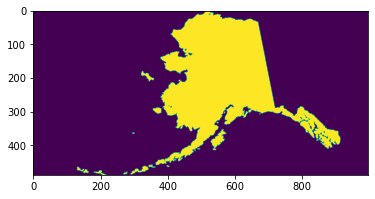

In [67]:
plt.imshow(old_slice)

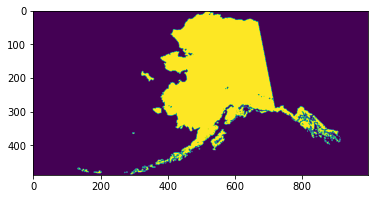

In [68]:
plt.imshow(new_slice)

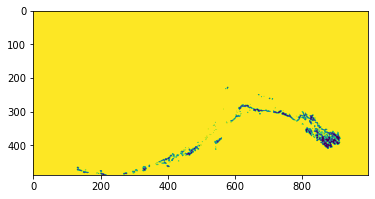

In [69]:
plt.imshow(slice_diff)

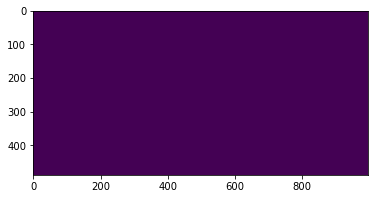

In [70]:
new_slice = ds_nanfix.sel(era=2, model=3, scenario=1).magt
old_slice = ds.sel(era=2, model=3, scenario=1).magt
slice_diff = new_slice - old_slice
plt.imshow(slice_diff)

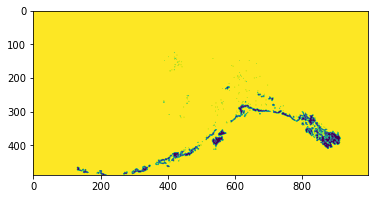

In [71]:
new_slice = ds_nanfix.sel(era=0, model=0, scenario=0).alt
old_slice = ds.sel(era=0, model=0, scenario=0).alt
slice_diff = new_slice - old_slice
plt.imshow(slice_diff)

In [72]:
del ds_nanfix["mask"]
ds_nanfix

<xarray.Dataset>
Dimensions:   (era: 5, model: 6, scenario: 3, y: 489, x: 997)
Coordinates:
  * era       (era) int64 0 1 2 3 4
  * model     (model) int64 0 1 2 3 4 5
  * scenario  (scenario) int64 0 1 2
  * y         (y) float64 2.373e+06 2.369e+06 2.365e+06 ... 4.254e+05 4.214e+05
  * x         (x) float64 -2.164e+06 -2.16e+06 -2.156e+06 ... 1.816e+06 1.82e+06
Data variables:
    magt      (era, model, scenario, y, x) float32 -9.999e+03 ... -9.999e+03
    alt       (era, model, scenario, y, x) float32 -9.999e+03 ... -9.999e+03
Attributes: (12/16)
    magt:        °C
    alt:         m
    1995:        0
    2025:        1
    2050:        2
    2075:        3
    ...          ...
    cruts31:     0
    gfdlcm3:     1
    gisse2r:     2
    ipslcm5alr:  3
    mricgcm3:    4
    ncarccsm4:   5

In [73]:
# specify encoding to compress
encoding = {"magt": {"zlib": True, "complevel": 9, "_FillValue": -9999.0},
            "alt": {"zlib": True, "complevel": 9, "_FillValue": -9999.0},
           }

In [74]:
ds_nanfix.to_netcdf("gipl_alt_magt_4km.nc", encoding=encoding)